
## 챠트로 나의 PC App사용 트랜드 살펴보기 

데이터에 숨어있는 시즈널한 패턴, 비이상적인 신호를 찾아내기 위해서는 데이터를 Plotting 해 보는 것만큼 좋은 것이 없다. 그중에서 요즘 개인적으로 많이 사용하는 Violin Plot으로 나의 2014년, 2015년 PC 사용 패턴을 그려 보고자 한다.



In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import math

## ploting theme 
#sns.set(style="whitegrid", palette="colorblind", color_codes=True, font_scale=1.4,
#        rc = {'font.size': 12, 'font.family':'NanumGothic'})

## 데이터셋 만들기 
2014, 2015 나의 PC에서 사용하는 프로그램별 사용시간 데이터 

In [10]:
!head ./resource/pc_usetime.csv

idx,uid,computername,shortsessionid,longsessionid,filename,title,catecode,usetime,jobclass,timestamp,inserttime,idate
1088,CHOIKYUMIN,CHOIKYUMIN,,,EXCEL.EXE,Microsoft Excel - 추천시스템 기능 기술 세분화.xlsx,6,270000,문서,1391404937,,
1089,CHOIKYUMIN,CHOIKYUMIN,,,chrome.exe,AfreecaTV Analytics :: Collaboration Search 검색어 - Chrome,2,5000,인터넷,1391404707,,
1090,CHOIKYUMIN,CHOIKYUMIN,,,chrome.exe,AfreecaTV Analytics :: Hot Boost Search Word - Chrome,2,5000,인터넷,1391404702,,
1091,CHOIKYUMIN,CHOIKYUMIN,,,chrome.exe,AfreecaTV Analytics :: Hot Broadcast by StarBalloon Cnt - Chrome,2,5000,인터넷,1391404712,,
1092,CHOIKYUMIN,CHOIKYUMIN,,,chrome.exe,AfreecaTV Analytics :: Starballoon Statistics - Chrome,2,15000,인터넷,1391404827,,
1093,CHOIKYUMIN,CHOIKYUMIN,,,chrome.exe,AfreecaTV Analytics :: pilot project~ - Chrome,2,40000,인터넷,1391404732,,
1094,CHOIKYUMIN,CHOIKYUMIN,,,chrome.exe,마이테이블 :: Pearson 상관계수(sample correlation coefficient) - Chrome,2,130000,인터넷,1391405107,,
1095,CHOIKYUMIN,CHOIKYUMIN,,,chrome.exe,"상대거리 계산 -

In [11]:
total_ds = pd.DataFrame.from_csv("./resource/pc_usetime.csv",index_col=None)
## type casting float to int 
total_ds[['usetime','timestamp']] = total_ds[['usetime','timestamp']].fillna(0).astype(int)

In [12]:
total_ds[13000:].head(2).T 

,13000,13001
idx,21244,21245
uid,CHOIKYUMIN,CHOIKYUMIN
computername,CHOIKYUMIN,CHOIKYUMIN
shortsessionid,1394520453.0,1394520453.0
longsessionid,1.394511e+09,1.394511e+09
filename,OUTLOOK.EXE,chrome.exe
title,받은 편지함 - goodvc@afreecatv.com - Microsoft Outlook,AfreecaTV Analytics :: Related Word Test Admin...
catecode,7,2
usetime,20000,160000
jobclass,기타업무,인터넷


### 확률 밀도를 그릴수 있도록 데이터 셋 변경 

In [13]:
## dataset 펼치기
data_arrays = []
for (idx, row) in total_ds.iterrows():
    for ut in range(0,int(row.usetime),5000):
        ts  = row.timestamp + round(ut/1000)
        now = datetime.fromtimestamp(ts)
        days = (now - datetime(now.year, 1, 1)).days+1
        data_arrays.append(['total', ts, now, now.year ,days, row.filename, row.jobclass])

## pandas 객체 생성 
fully_expended_ds = pd.DataFrame(data_arrays, columns=['total', 'ts', 'time', 'year', 'days', 'filename', 'jobclass'])
## 주요 필드 만들기 
## quater label 
fully_expended_ds['YYYYQt'] = fully_expended_ds.time.apply(lambda x : "%d' %dQ" % (x.year-2000, x.quarter))
## day trend values 
fully_expended_ds['day-minute'] = fully_expended_ds.time.apply(lambda x : x.hour*60+x.minute)
## hour label
fully_expended_ds['hour'] = fully_expended_ds.time.apply(lambda x :  "%dh" % (math.ceil((x.hour+1)/3)*3 ) )
## month label
fully_expended_ds['month'] = fully_expended_ds.time.apply(lambda x : x.month)
## week label
weekday_str = '월 화 수 목 금 토 일'.split()
fully_expended_ds['weekday'] = fully_expended_ds.time.apply(lambda x : weekday_str[x.weekday()])
## app rank 
apps_stat = total_ds.groupby(['filename']).sum().sort(['usetime'], ascending=False).reset_index()[['filename','usetime']]
apps_stat['rank'] = range(1,apps_stat.shape[0]+1)
fully_expended_ds = pd.merge(fully_expended_ds, apps_stat, on='filename')

## 
* 출근 - 퇴근
* 몇시간을 일하고 
* 어떤 프로그램을 많이 쓰고 


In [23]:
## 월~ 금
work_week_day = '월 화 수 목 금'.split()

pgm_time_ds = fully_expended_ds[fully_expended_ds.weekday.isin(work_week_day)]

In [30]:
pgm_time_ds['ts2'] = pgm_time_ds.ts

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [34]:
work_time_ds = pgm_time_ds.groupby(['year','days']).agg({'ts':np.min, 'ts2':np.max})

In [46]:
def toMinute(x):
    date_val = datetime.fromtimestamp(x)
    return date_val.hour*60+date_val.minute

work_time_ds['start_tm'] = work_time_ds.ts.apply(toMinute)
work_time_ds['end_tm'] = work_time_ds.ts2.apply(toMinute)

In [81]:
def toHour(hour_min):
    return "%d:%d" % (math.floor(hour_min/60), math.floor(hour_min%60))

mean_tmp_ds = work_time_ds.groupby(level=0).mean()
print("출근시간", mean_tmp_ds.start_tm.apply(toHour))
print("퇴근시간", mean_tmp_ds.end_tm.apply(toHour))
print("근무시간", toHour((mean_tmp_ds.end_tm - mean_tmp_ds.start_tm).mean()) )

출근시간 year
2014    8:19
2015    8:22
Name: start_tm, dtype: object
퇴근시간 year
2014    19:27
2015     19:1
Name: end_tm, dtype: object
근무시간 10:53


In [89]:
search_ds = total_ds[total_ds.title.apply(lambda x: str(x).find(u'검색')>-1)]

In [118]:
search_words = []
for title in search_ds.title:
    title = title.replace(':','-')
    words = title.split('-')
    
    if len(words)<3:
        continue
    
    if words[1].strip() in ['Google 검색','네이버 통합검색' ]:
        
        search_words.extend(words[0].lower().split())
    

In [128]:
searchwords_ds = pd.DataFrame(search_words)
searchwords_ds.columns = [u'나의 검색어']
#searchwords_ds.searchwords_ds

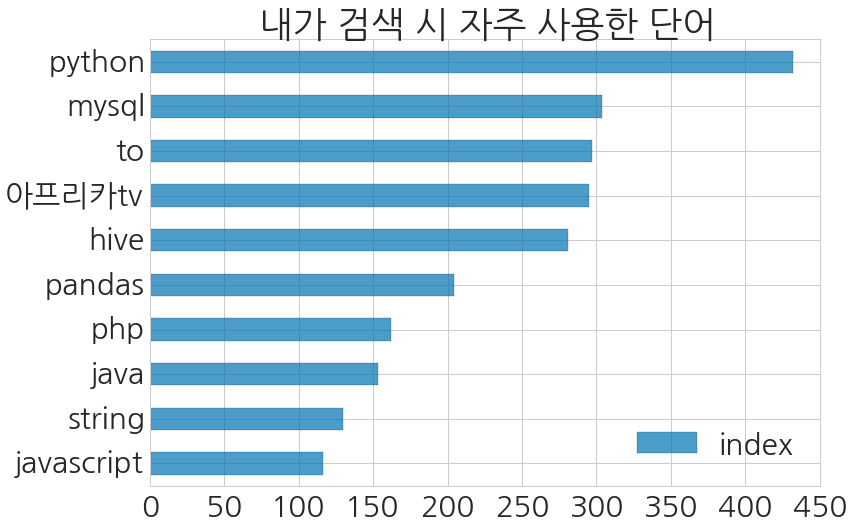

In [154]:
sns.set(style="whitegrid", palette="colorblind", color_codes=True, font_scale=3,
        rc = {'font.size': 16, 'font.family':'NanumGothic'})
searchwords_ds.reset_index().groupby(u'나의 검색어').count().sort('index', ascending=False)[:10]\
    .sort('index', ascending=True)\
    .plot(kind='barh', figsize=(12,8), alpha=.7, title="내가 검색 시 자주 사용한 단어")
plt.ylabel('')

## 바이올린 챠트 그리기
* 바이올린 챠트는 입력 데이터에 대한 box plot과 커널 밀도 추정(Kernel Density Estimation) Plot을 카타고리컬하게 표현하는 챠트이다.
* 중앙에 있는 box-plot대신 stick, point

### 2014,2015년도 나의 PC사용 시간을 1년(1~365)을 기준으로 바이올린 Plot으로 보기 

In [69]:
import seaborn as sns
# plot style 
sns.set(style="whitegrid", palette="colorblind", font_scale=1.4, rc={'font.family':'NanumGothic'} )

## 2개 그룹를 하나의 Violin으로 Plotting하는 hue 설정

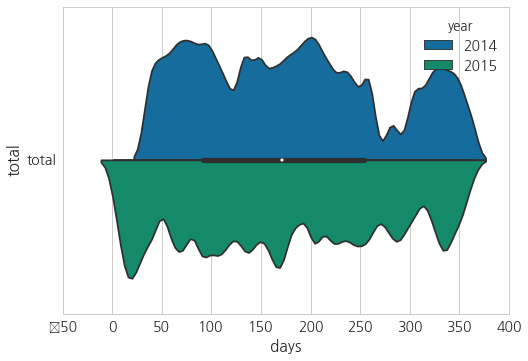

In [70]:
sns.violinplot(data=fully_expended_ds, x='days',y='total', hue='year', split=True )

## 보기 좋게 다듬기 

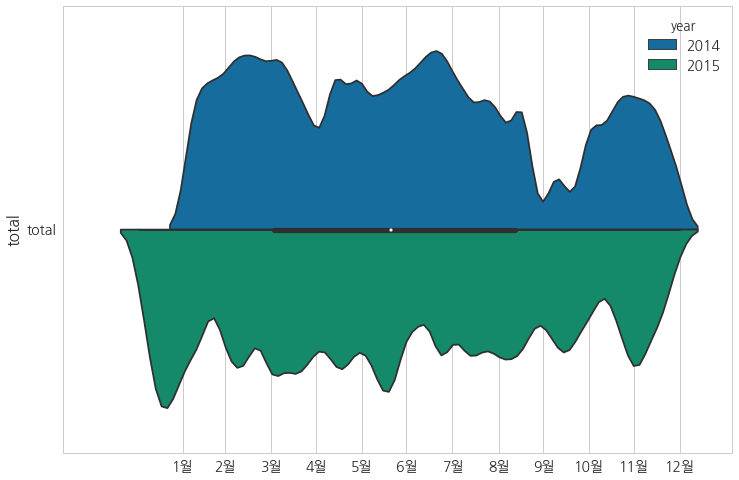

In [71]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid", palette="colorblind", color_codes=True, font_scale=1.4,
        rc = {'font.size': 12, 'font.family':'NanumGothic'})
## ploting
g = sns.violinplot(data=fully_expended_ds, x='days', y='total', hue='year'
                   , scale="width", orient='h', split=True, cut=2 )
## draw x-ticks
ticks = fully_expended_ds.groupby('month').max()[['days']]
plt.xticks( ticks.days.tolist(), [ "%d월" % m for m in ticks.index.tolist()] )
plt.xlabel('')
## set x-axis range
plt.xlim(-50, 400)
plt.show()

In [72]:
tmp_ds = fully_expended_ds[fully_expended_ds['year']==2015].groupby(['YYYYQt','days']).count()[['usetime']].reset_index()
tmp_ds = tmp_ds[tmp_ds['usetime']>12*120]
(tmp_ds.groupby('YYYYQt').mean()[['usetime']]*5/60/60).T

YYYYQt,15' 1Q,15' 2Q,15' 3Q,15' 4Q
usetime,6.987449,6.924741,6.291538,5.447402


## Y축을 여러개의 그룹을 Plotting하기 


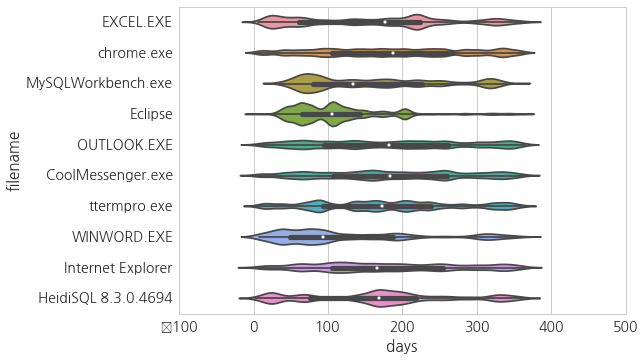

In [73]:
sns.violinplot(data=fully_expended_ds[fully_expended_ds['rank']<11], x='days', y='filename' )

##  깔끔하게 다듬에서 Plotting 하기 
### 주요 Parameters 
* y : 카테고리
* hue : 카테고리 
* scale : 각각의 카테고리별 violin의 width의 scaling을 하기 위한 옵션 
* bw : Kernel의 Band width를 나타낸다 

In [74]:
import seaborn as sns

## 다듬어진 Violin Plotting하기 
def drawViolin(ds, x, y, hue, label=None, figsize=(14,50), order=None, scale='width') :
    sns.set(style="whitegrid", palette="colorblind", font_scale=1.4, rc={'font.family':'NanumGothic'} )
    plt.figure(figsize=figsize)
    order_list = order or ds.groupby(y).count().sort(x, ascending=False).index.tolist()
    
    ## ploting
    g = sns.violinplot(data=ds, x=x, y=y, hue=hue, scale=scale, orient='h'
                       , cut=2, split=True, inner='box'
                       , order = order_list
                      )
    plt.tick_params(labeltop='on')

    if label != None:
        ## x ticks
        label_ds = ds.groupby(label).max()
        x_index = label_ds[x].values.tolist()
        x_label = label_ds.index.tolist()
        plt.xticks(x_index, x_label, rotation='vertical')

    plt.xlabel('')
    plt.ylabel('')
    

## PC App별 사용시간 변화 보기 

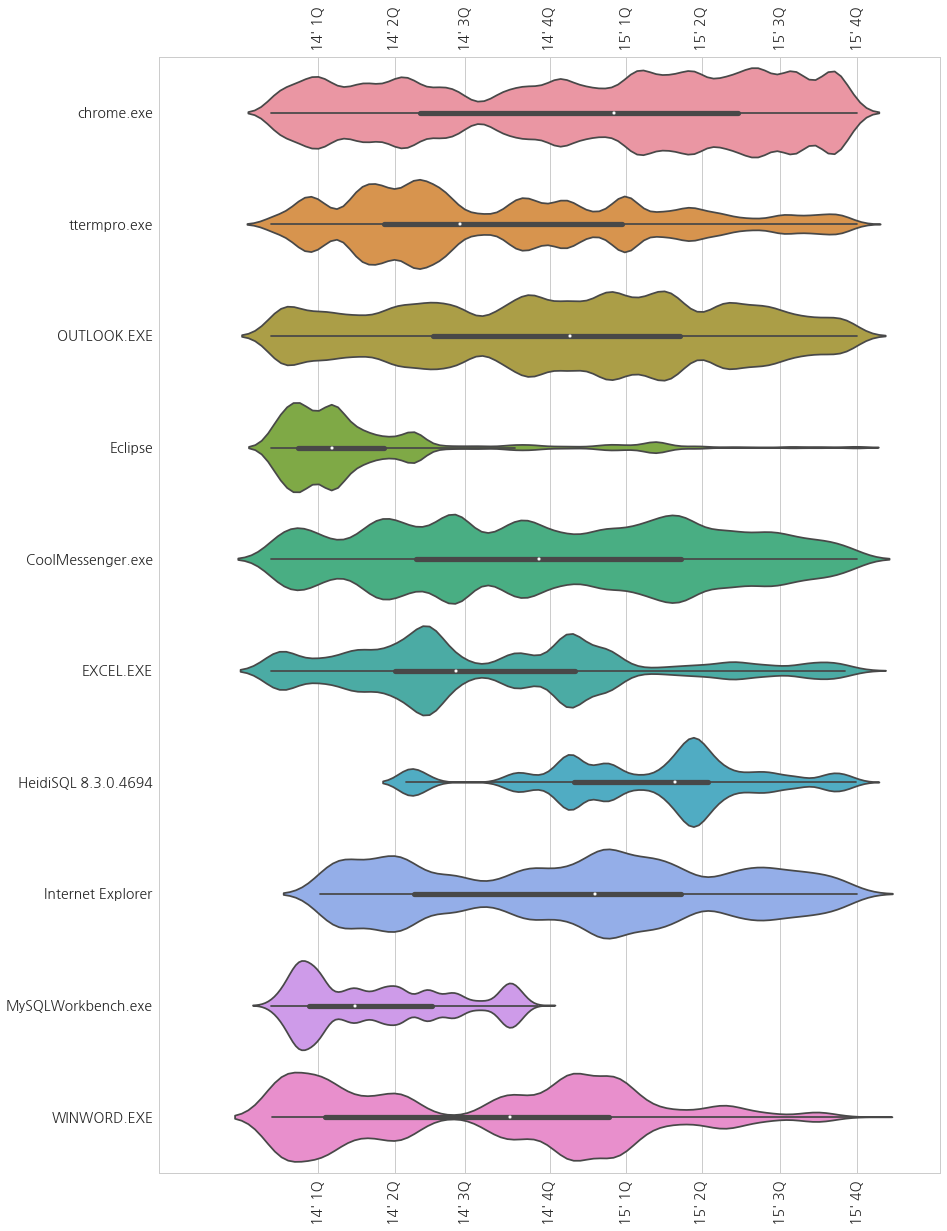

In [75]:
drawViolin(fully_expended_ds[fully_expended_ds['rank']<11], x='ts', y='filename', hue=None, label='YYYYQt', figsize=(14,20))

## 이 PC App별로 부류를 만들어 트랜드 산출해보면 

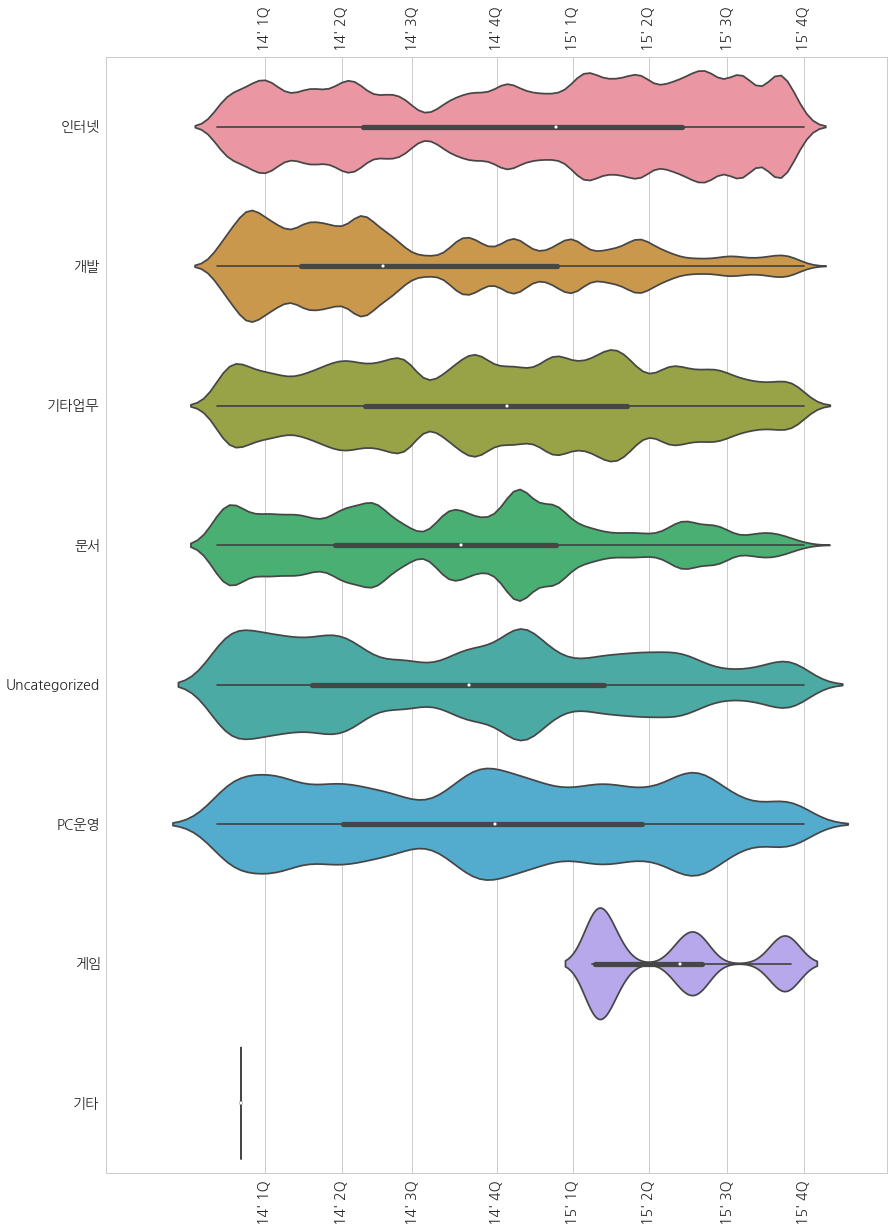

In [76]:
drawViolin(fully_expended_ds, x='ts', y='jobclass', hue=None, label='YYYYQt', figsize=(14,20))

## 시간대별 PC 사용량 변화 보기

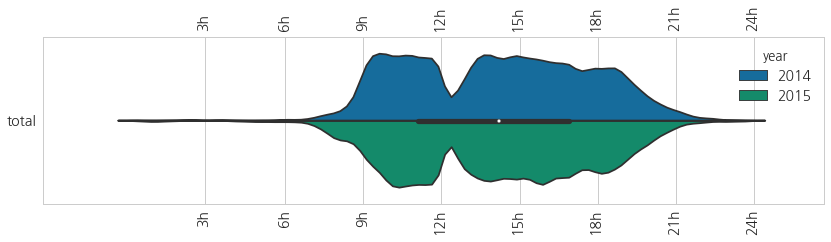

In [77]:
drawViolin(fully_expended_ds, x='day-minute', y='total', hue='year', label='hour', figsize=(14,3))

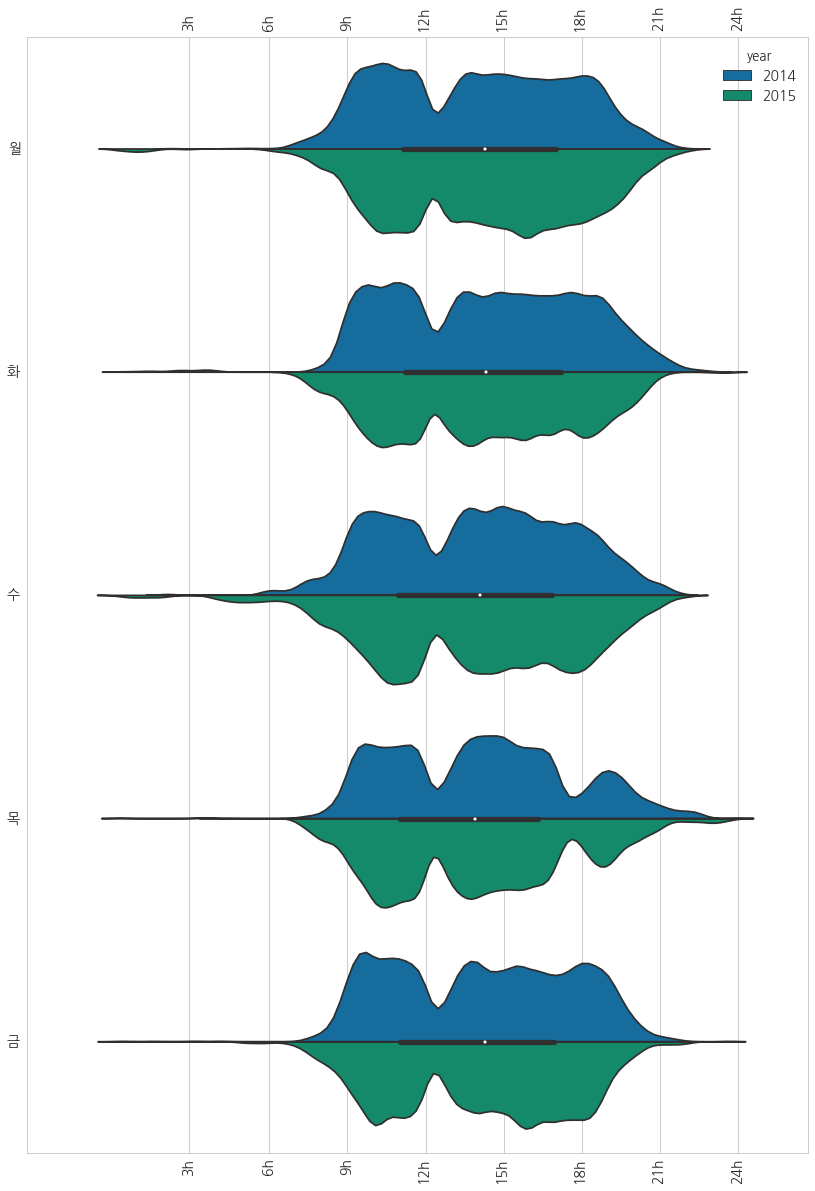

In [78]:
weekday_str = '월 화 수 목 금'.split()
drawViolin(fully_expended_ds[fully_expended_ds['weekday'].isin(weekday_str)], x='day-minute', y='weekday'
             , hue='year', label='hour', figsize=(14,20), order=weekday_str, scale='count')